# CS551G_Assessment2_ZHIXI_TANG_52097136
Student Name: ZHIXI TANG \
Student ID: 52097136

Description: This file contains the source code of CS551G Assessment 2, Task 2

## Task 2: Develop distributed models in apache spark to classify gas turbines

#### Configure the environment of Spark

In this part, we will install the essential packages, configure the environment for Pyspark. Firstly, we will install java JVM and configure the environment path. Secondly, we will download the pyspark package from internet, install and configure the environment path. Thirdly, we will create a Spark app named "Assessment 2", and upload the dataset on Colab.

In [ ]:
import os
def install_jave():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null  # openjdk installation
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"   # set environment variables
    !java -version  # check java version

install_jave()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [ ]:
# Download spark from internet
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

In [ ]:
# Decompress the file we downloaded from the last cell code
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

In [ ]:
# Using pip to install findspark
!pip install -q findspark

In [ ]:
# Configure the envrionment of spark
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
# Create app named "AssessmentII"
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("AssessmentII").getOrCreate()

In [ ]:
# Upload the dataset
from google.colab import files
files.upload()

Saving CS551G_DMV_Assessment_2_Dataset.xlsx to CS551G_DMV_Assessment_2_Dataset.xlsx


{'CS551G_DMV_Assessment_2_Dataset.xlsx': b'PK\x03\x04\x14\x00\x06\x00\x08\x00\x00\x00!\x00\x87V\xe12\x86\x01\x00\x00\x99\x06\x00\x00\x13\x00\x08\x02[Content_Types].xml \xa2\x04\x02(\xa0\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

#### Subtask 2.1, Creating a Table Containing Summary Information

Here we will read the dataset. Since PySpark can only read dataset from .json, .csv file. I will use Pandas read the .xlsx file as pandas.DataFrame then convert it to Spark.DataFrame.

The Task 2.1 is creating a table showing the sumary information of this dataset.(mean values, range, standard deviations, min/max values, median values, and 25%/50%/75% percentile values. My solution is shown as the following:
- Using spark.DataFrame.describe() function, it will return a spark.DataFrame include the summary information of counts, mean, standard deviation, min, max.
- From the above function we can know the min and max value of each column, so we can get $range = max - min$. We will create a new spark.DataFrame to store these values then combine with the previous spark.DataFrame.
- Using mathmatic calculation functions of pandas.DataFrame _(i.g, df.median(),df.quantile(), and so on)_. We can get the rest values of summary information. Then we will create a new spark.DataFrame, then combine with the previous Spark.DataFrame.

In [ ]:
# read the file via pandas
import pandas as pd
df = pd.read_excel("/content/CS551G_DMV_Assessment_2_Dataset.xlsx")
# convert Pandas.DataFrame to Spark.DataFrame
spark_df = spark.createDataFrame(df)
# spark_df.show()

In [ ]:
# Calculate the range for each column
def calculate_range(dataframe_description):
    columns = dataframe_description.columns
    dic = {'summary':'range'}
    rows = dataframe_description.collect()
    for i in columns:
        if i == 'summary':
            continue
        else:
            range = float(rows[4][i])-float(rows[3][i])
            dic[i] = range
    df_range = pd.DataFrame(dic, index=[0])
    df_range = spark.createDataFrame(df_range)  # convert from pandas to spark
    dataframe_description = dataframe_description.union(df_range) # TODO: add this DataFrame to df_des
    return dataframe_description

In [ ]:
# calculate median for each column
def calculate_median(dataframe_description, pandas_dataframe):
    medians = pandas_dataframe.median() # 是个序列

    df_median = pd.DataFrame([[value for value in medians]], columns=[column for column in medians.index])

    df_median.insert(0, 'summary', ['median'])
    df_median = spark.createDataFrame(df_median)
    dataframe_description = dataframe_description.union(df_median)

    return dataframe_description

In [ ]:
# calculate 25%, 50%, 75% percentile for each column
def calculate_quantile(dataframe_description, pandas_dataframe):
    q_25 = df.quantile(0.25)
    q_50 = df.quantile(0.5)
    q_75 = df.quantile(0.75)
    columns = q_25.index
    df_quantile = pd.DataFrame([
                                [a for a in q_25],
                                [a for a in q_50],
                                [a for a in q_75]],
                            columns=columns
                            )
    df_quantile.insert(0, 'summary', ['25% quantile', '50% quantile', '75% quantile'])
    df_quantile = spark.createDataFrame(df_quantile)
    dataframe_description = dataframe_description.union(df_quantile)

    return dataframe_description

In [ ]:
# summary description of dataset
def description(spark_dataframe, pandas_dataframe):
    spark_dataframe = spark_dataframe.drop('Status')
    df_des = spark_dataframe.describe()   # Spark DataFrame include mean, std, min, max, count
    
    # TODO: calculate range for each column
    df_des = calculate_range(df_des)

    # TODO: calculate median value for each column
    df_des = calculate_median(df_des, pandas_dataframe)
        
    # TODO: calculate 25%/50%/75% percentiles for each column
    df_des = calculate_quantile(df_des, pandas_dataframe)
    return df_des

In [ ]:
# Show the table containing summary information
a = description(spark_df, df)
a.show()

+------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     summary|Temperature_Sensor_1|Temperature_Sensor_2|Temperature_Sensor_3|Flow_Rate_Sensor_1|Flow_Rate_Sensor_1.1|Flow_Rate_Sensor_1.2|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Vibration_Sensor_1|Vibration_Sensor_2|Vibration_Sensor_3|
+------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|       count|                 996|                 996|                 996|               996|                 996|                 996|               996|               996|               996|               996|               996|        

#### Subtask 2.2 Drawing Images

In Task 2.2, we will draw two plots and interpret what information we can get from these plots. The first one is a boxplot containing two classes ( normal and abnormal) vibration_sensor_1 values. The second one is a scatterplot that also containing two class values of vibration_Sensor_1 against vibration_Sensor_2.

**Solutions**:

For the first plot, as the assessment mentioned, we can use HandySpark. There is a function in HandySpark called stratify. We use this function to stratify the whole HandSpark.DataFrame according to Status (normal or abnormal). Then we can plot as required.

For the second plot, there are two solutions: 

1. We use the function of HandySpark.cols to extract the values from columns "Status", "Vibration_Sensor_1", and "Vibration_Sensor_2". It will return a pandas.DataFrame. Then we use SeaBorn creating a SeaBorn.FacetGrid object to plot the figure. 

2. Firstly, we use Spark.filter() to create two spark.DataFrames classified by the "Status" column. Then we convert them to HandySpark DataFrame. Extracting the values of "Vibration_Sensor_1", and "Vibration_Sensor_2" by HandySpark.cols, we will get two pandas.DataFrames. Then we use matplotlib to plot two figures then combine them together. 

In [ ]:
# install handyspark
!pip install -q handyspark

     |████████████████████████████████| 212.3MB 75kB/s 
     |████████████████████████████████| 204kB 21.4MB/s 


In [ ]:
from handyspark import *

(<Figure size 576x432 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f0f55eb1a90>])

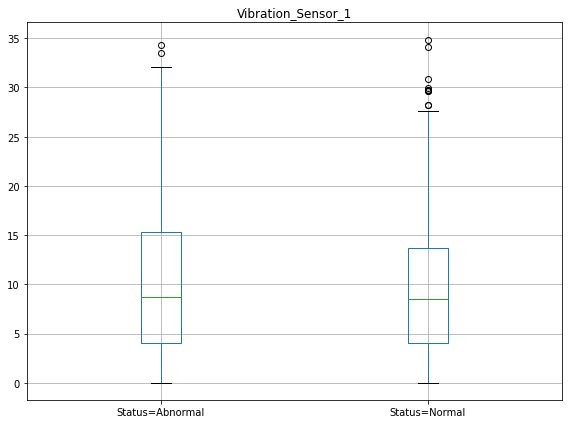

In [ ]:
h_df = spark_df.toHandy() # convert Spark.DataFrame to Handy.DataFrame
h_df.stratify(['Status']).cols['Vibration_Sensor_1'].boxplot(figsize=(8,6)) # plot the figure

**Obtained Information (boxplot)**:

<font color=red>(_The numbers in the below content is approximately recognized from the figure_)</font>

From the above figure, we can tell that the range of Vibration Sensor 1 abnormal values is from 0 to 32.5. Any values are greater than 32.5 would be counted as the outlier (There are two), the 25% quantile value of this dataset is around 4.1. The median value is around 8. 75% quantile is around 15.5. 
Similarly, in the dataset of normal vibration sensor 1,  the value range is from around 0 to 27.5. Any values are greater than 27.5 would be counted as the outlier ( There are more than 4 outliers). The 25% quantile of this dataset is around 4.1, the median value is around 8, the 75% quantile is around 13.5. 

**Conclusion**:

The normal vibration sensor 1 has more outliers than the abnormal sensor. normal sensor's value range is smaller than the abnormal sensor. Their minimum values, median values, and 25% quantiles are almost the same but the maximum value and 75% quantile of Abnormal sensor is greater than Normal sensor.


INFO: Safety is ON - returning up to 1000 instances.


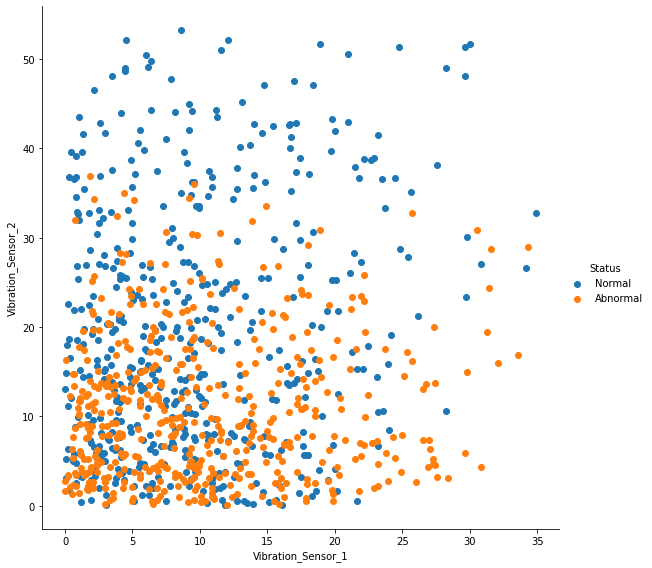


INFO: Safety is ON - returning up to 1000 instances.

INFO: Safety is ON - returning up to 1000 instances.


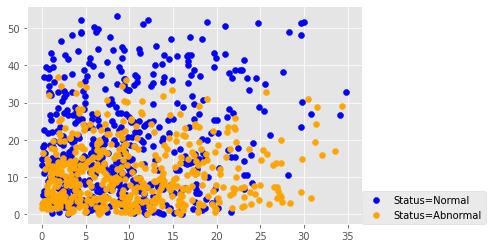

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Solution - 1
status = ['Normal', 'Abnormal']
data = h_df.cols[['Status', 'Vibration_Sensor_1', 'Vibration_Sensor_2']][:]

fg = sns.FacetGrid(data=data, hue='Status', hue_order=status, height=8, aspect=1)
fg.map(plt.scatter, 'Vibration_Sensor_1', 'Vibration_Sensor_2').add_legend()
plt.show()

# Solution - 2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Split the dataframe by Status = 'Normal' and 'Abnormal'
d1 = spark_df.filter(spark_df.Status == 'Normal').toHandy().cols[['Status', 'Vibration_Sensor_1', 'Vibration_Sensor_2']][:]
d2 = spark_df.filter(spark_df.Status == 'Abnormal').toHandy().cols[['Status', 'Vibration_Sensor_1', 'Vibration_Sensor_2']][:]

# drawing image of normal and abnormal status individually. 
plt.scatter(d1['Vibration_Sensor_1'], d1['Vibration_Sensor_2'], color='blue', label='Status=Normal')
plt.scatter(d2['Vibration_Sensor_1'], d2['Vibration_Sensor_2'], color='orange', label='Status=Abnormal')

plt.legend(loc=(1,0))
plt.show()

**Obtained Information (boxplot)**:

<font color=red>__The numbers in the below content is approximately recognized from the figure__</font>

__Here we say Vibration Sensor 1 as VS1, Vibration Sensor 2 as VB2.__

As we can see from the above figure, regarding the distribution of VS1 and VS2 values, the overall distribution of normal values is looser than the abnormal values. For the values of both statuses, when VS1 increases, its distribution becomes looser. For a fixed VS1 interval, the distribution of normal values is more uniform than abnormal values. The values of abnormal are mainly concentrated in the range of $VS1 \in [0, 15]$, the corresponding interval of VS2 is $[0, 20]$

#### Subtask 2.3 Train a Random Forest Model via Spark

For this task, we will use all the columns but column "Status" as the input features to generate a feature to classify the Status, the following are the steps:
1. As we will classify the dataset as normal ( represented by 1) and abnormal ( represented by 0 ). so we will adding an additional column in the Spark.DataFrame named "Status_Value", the values of this column depend on its status (1 for normal, 0 for abnormal). 

2. When I was trying to create a Spark.Assembler, the Python compiler reported an error about the data type of column "Flow_Rate_Sensor1.1" and "Flow_Rate_Sensor1.1", the compiler indicated the needed data type is struct type but I think both data types should be Double and they are indeed Double, so I changed their column names as "Flow_Rate_Sensor_2" and "Flow_Rate_Sensor_3". 

3. Transform the data, putting all the features(all the columns of the Spark.DataFrame but column "Status" and "Status_Value") into one vector. Get the predictor column as output. Choose the column "predictors" and "Status_Value" as the values to build a model for the training of the Random Forest Classifier. 

4. Build the model. 

5. Evaluate the model. Print the accuracy, precision, and AUROC. 

In [ ]:
df1 = spark_df.filter(spark_df.Status == 'Normal')
df2 = spark_df.filter(spark_df.Status == 'Abnormal')

df1 = df1.withColumn('Status_Value', df1.Temperature_Sensor_1 * 0 + 1)
# df1.show(5)
df2 = df2.withColumn('Status_Value', df2.Temperature_Sensor_1 * 0)
# df2.show(5)
new_DF = df1.union(df2)

In [ ]:
new_DF.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Temperature_Sensor_1: double (nullable = true)
 |-- Temperature_Sensor_2: double (nullable = true)
 |-- Temperature_Sensor_3: double (nullable = true)
 |-- Flow_Rate_Sensor_1: double (nullable = true)
 |-- Flow_Rate_Sensor_1.1: double (nullable = true)
 |-- Flow_Rate_Sensor_1.2: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Vibration_Sensor_1: double (nullable = true)
 |-- Vibration_Sensor_2: double (nullable = true)
 |-- Vibration_Sensor_3: double (nullable = true)
 |-- Status_Value: double (nullable = true)



In [ ]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType

# Change the names of two columns
new_DF=new_DF.withColumnRenamed('Flow_Rate_Sensor_1.1', 'Flow_Rate_Sensor_2')
new_DF=new_DF.withColumnRenamed('Flow_Rate_Sensor_1.2', 'Flow_Rate_Sensor_3')
# spark_df.show(5)
inputCols = [
             'Temperature_Sensor_1','Temperature_Sensor_2','Temperature_Sensor_3',
             'Flow_Rate_Sensor_1','Flow_Rate_Sensor_2','Flow_Rate_Sensor_3',
             'Pressure _sensor_1','Pressure _sensor_2','Pressure _sensor_3',
             'Vibration_Sensor_1','Vibration_Sensor_2','Vibration_Sensor_3'
]
assembler = VectorAssembler(inputCols=inputCols, outputCol = 'predictors')
predictors = assembler.transform(new_DF)
predictors.show(5)

+------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+
|Status|Temperature_Sensor_1|Temperature_Sensor_2|Temperature_Sensor_3|Flow_Rate_Sensor_1|Flow_Rate_Sensor_2|Flow_Rate_Sensor_3|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Vibration_Sensor_1|Vibration_Sensor_2|Vibration_Sensor_3|Status_Value|          predictors|
+------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------+--------------------+
|Normal|              4.5044|              0.7443|                6.34|            1.9052|           29.5315|            0.8647|            2.2044|             6.048|   

In [ ]:
model_data = predictors.select('predictors', 'Status_value')
model_data.show(5, truncate=False)

+----------------------------------------------------------------------------------------+------------+
|predictors                                                                              |Status_value|
+----------------------------------------------------------------------------------------+------------+
|[4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186]   |1.0         |
|[4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483]|1.0         |
|[4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408]  |1.0         |
|[5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157]   |1.0         |
|[5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966]  |1.0         |
+----------------------------------------------------------------------------------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Split the data into training and test sets (30% held for testing)
train_data, test_data = model_data.randomSplit([0.7, 0.3])

# Print the details of train_data and test_data
print("train_data set:%d, columns: %d" % (train_data.count(), len(train_data.columns)))
print("test_data set:%d, columns: %d" % (test_data.count(), len(test_data.columns)))

# create a model using the predicators created above using as labels the Status
# fit and avaliate the model on test data
rf = RandomForestClassifier(labelCol='Status_value', featuresCol='predictors', numTrees=5000)
rfModel = rf.fit(train_data)

train_data set:702, columns: 2
test_data set:294, columns: 2


In [ ]:
train_data.printSchema()

root
 |-- predictors: vector (nullable = true)
 |-- Status_value: double (nullable = true)



In [ ]:
rf_pred = rfModel.transform(test_data)

In [ ]:
rf_pred.show()
rf_pred.count()

+--------------------+------------+--------------------+--------------------+----------+
|          predictors|Status_value|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.1382,4.9429,8....|         1.0|[3444.58629962547...|[0.68891725992509...|       0.0|
|[0.1447,5.5261,7....|         1.0|[1675.23973089464...|[0.33504794617892...|       1.0|
|[0.2325,4.9466,6....|         1.0|[1770.93699158374...|[0.35418739831674...|       1.0|
|[0.2811,4.52,8.04...|         1.0|[3664.15930907618...|[0.73283186181523...|       0.0|
|[0.4724,4.9612,8....|         1.0|[3410.41685892129...|[0.68208337178425...|       0.0|
|[1.279,9.2706,10....|         1.0|[655.333615340037...|[0.13106672306800...|       1.0|
|[1.3065,5.3293,7....|         1.0|[2950.19771405886...|[0.59003954281177...|       0.0|
|[1.3843,5.9976,8....|         1.0|[1970.46144679401...|[0.39409228935880...|       1.0|
|[1.4502,4.3204,7....

294

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf_accuracy = MulticlassClassificationEvaluator(
    labelCol='Status_value', metricName='accuracy'
).evaluate(rf_pred)
print("The accuracy is %f" % rf_accuracy)

rf_precision = MulticlassClassificationEvaluator(
    labelCol='Status_value', metricName='weightedPrecision'
).evaluate(rf_pred)
print("The precision is %f" % rf_precision)

rf_auroc = MulticlassClassificationEvaluator(
    labelCol='Status_value'
).evaluate(rf_pred)
print("The AUROC is %f" % rf_auroc)


The accuracy is 0.843537
The precision is 0.844635
The AUROC is 0.843100


In [ ]:
rfModel.featureImportances

SparseVector(12, {0: 0.116, 1: 0.1552, 2: 0.1334, 3: 0.1827, 4: 0.0302, 5: 0.0189, 6: 0.0511, 7: 0.0439, 8: 0.0174, 9: 0.0175, 10: 0.1674, 11: 0.0663})

In [ ]:
model_data.schema['predictors'].metadata['ml_attr']['attrs']

{'numeric': [{'idx': 0, 'name': 'Temperature_Sensor_1'},
  {'idx': 1, 'name': 'Temperature_Sensor_2'},
  {'idx': 2, 'name': 'Temperature_Sensor_3'},
  {'idx': 3, 'name': 'Flow_Rate_Sensor_1'},
  {'idx': 4, 'name': 'Flow_Rate_Sensor_2'},
  {'idx': 5, 'name': 'Flow_Rate_Sensor_3'},
  {'idx': 6, 'name': 'Pressure _sensor_1'},
  {'idx': 7, 'name': 'Pressure _sensor_2'},
  {'idx': 8, 'name': 'Pressure _sensor_3'},
  {'idx': 9, 'name': 'Vibration_Sensor_1'},
  {'idx': 10, 'name': 'Vibration_Sensor_2'},
  {'idx': 11, 'name': 'Vibration_Sensor_3'}]}

#### Subtask 2.4 Train a Multilayer Perceptron Classifier via Spark

In [ ]:
# Multilayer perception classifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split the data into training and test sets (30% held for testing)
train_data, test_data = model_data.randomSplit([0.7, 0.3])

# Print the details of train_data and test_data
print("train_data set:%d, columns: %d" % (train_data.count(), len(train_data.columns)))
print("test_data set:%d, columns: %d" % (test_data.count(), len(test_data.columns)))

# specify layers for the neural network:
# input layer of size 12 (features), two intermediate of size 5 and 4
# output layer of size 2 (classes)
layers = [12, 5, 4, 2]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(labelCol='Status_value', 
                                         featuresCol='predictors',
                                         maxIter=100, layers=layers,
                                         blockSize=128, seed=1234)

# train the model
model = trainer.fit(train_data)

# evaluate the model
result = model.transform(test_data)

train_data set:702, columns: 2
test_data set:294, columns: 2


In [ ]:
# result = result.select('Status_value', 'prediction')
result.show()
result.printSchema()

+--------------------+------------+--------------------+--------------------+----------+
|          predictors|Status_value|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.1117,6.2585,6....|         1.0|[-0.7245000693661...|[0.31327432793309...|       1.0|
|[0.1382,4.9429,8....|         1.0|[0.04717840454591...|[0.57652035482786...|       0.0|
|[0.4724,4.9612,8....|         1.0|[0.04771031616498...|[0.57673586913661...|       0.0|
|[0.9549,5.4639,6....|         1.0|[0.04186252738368...|[0.57436654047241...|       0.0|
|[1.3065,5.3293,7....|         1.0|[0.50791093986541...|[0.74729252245393...|       0.0|
|[1.4841,10.0012,1...|         1.0|[-1.7214104471105...|[0.07658315980560...|       1.0|
|[1.6333,9.2532,10...|         1.0|[0.05432155746260...|[0.57945826616700...|       0.0|
|[1.6635,5.2606,8....|         1.0|[0.04185232829038...|[0.57436255930083...|       0.0|
|[1.6681,5.8282,6....

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf_accuracy = MulticlassClassificationEvaluator(
    labelCol='Status_value', metricName='accuracy'
).evaluate(result)
print("The accuracy is %f" % rf_accuracy)

rf_precision = MulticlassClassificationEvaluator(
    labelCol='Status_value', metricName='weightedPrecision'
).evaluate(result)
print("The precision is %f" % rf_precision)

rf_auroc = MulticlassClassificationEvaluator(
    labelCol='Status_value'
).evaluate(result)
print("The AUROC is %f" % rf_auroc)

The accuracy is 0.704082
The precision is 0.705190
The AUROC is 0.701636


fit 之后的数据模型transform得到的dataframe有问题，里面只保留了normal标签的数据，abnormal都丢失掉了。
明天在load_data 的这个阶段重新处理一下。把Status 替换为 Status_value, 试一试，如果还是不行，就写邮件给老师。
明天要开始写assessment1 了